# Profiling and Optimising


**Optimising** is the process of making your code 'better' by some metric.
Most often, this is total runtime (how long it takes),
but can also mean things like reducing memory usage or any other way to measure the 'cost' of your code.

**Profiling** is a way of measuring your code,
to figure out what part of it you may want to to optimize.

IPython provides some tools that can make it it a bit easier to profile and optimise your code sometimes.

For more information on IPython, see [our IPython notes](../python/ipython.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## `%timeit`

The main IPython tool we are going to use here is `%timeit`,
a magic that automates measuring how long it takes to run a snippet of code.

In [2]:
for N in (100, 500, 1000, 2000):
    print(f"Size: {N} x {N}")
    A = np.random.random((N, N))
    %timeit A.dot(A)

Size: 100 x 100
56.9 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Size: 500 x 500
2.88 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: 1000 x 1000
18 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: 2000 x 2000
118 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's look at what options `%timeit` can take.

In [3]:
%timeit?

Docstring:
Time execution of a Python statement or expression

Usage, in line mode:
  %timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] statement
or in cell mode:
  %%timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] setup_code
  code
  code...

Time execution of a Python statement or expression using the timeit
module.  This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, the statement in the first line is used as setup code
  (executed but not timed) and the body of the cell is timed.  The cell
  body has access to any variables created in the setup code.

Options:
-n<N>: execute the given statement <N> times in a loop. If <N> is not
provided, <N> is determined so as to get sufficient accuracy.

-r<R>: number of repeats <R>, each consisting of <N> loops, and take the
best result.
Default: 7

-t: use time.time to measure the time, which is the default on Unix.
This f

We can save the result in an object with `%timeit -o`,
and specify to only run one group of 100 iterations.

In [4]:
A = np.random.random((100, 100))
tr = %timeit -o -n 1 -r 100 A.dot(A)

The slowest run took 427.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1.23 ms ± 2.73 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [5]:
tr

<TimeitResult : 1.23 ms ± 2.73 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)>

In [6]:
tr.best

4.054198507219553e-05

In [7]:
tr.best, tr.worst

(4.054198507219553e-05, 0.017338457982987165)

In [8]:
print(len(tr.all_runs))
tr.all_runs[:10]

100


[0.017338457982987165,
 0.0036002080014441162,
 0.005538375000469387,
 0.007218124985229224,
 0.009809334005694836,
 0.00333579201833345,
 0.002126000006683171,
 0.0009002919832710177,
 0.00022325001191347837,
 0.0046943339984864]

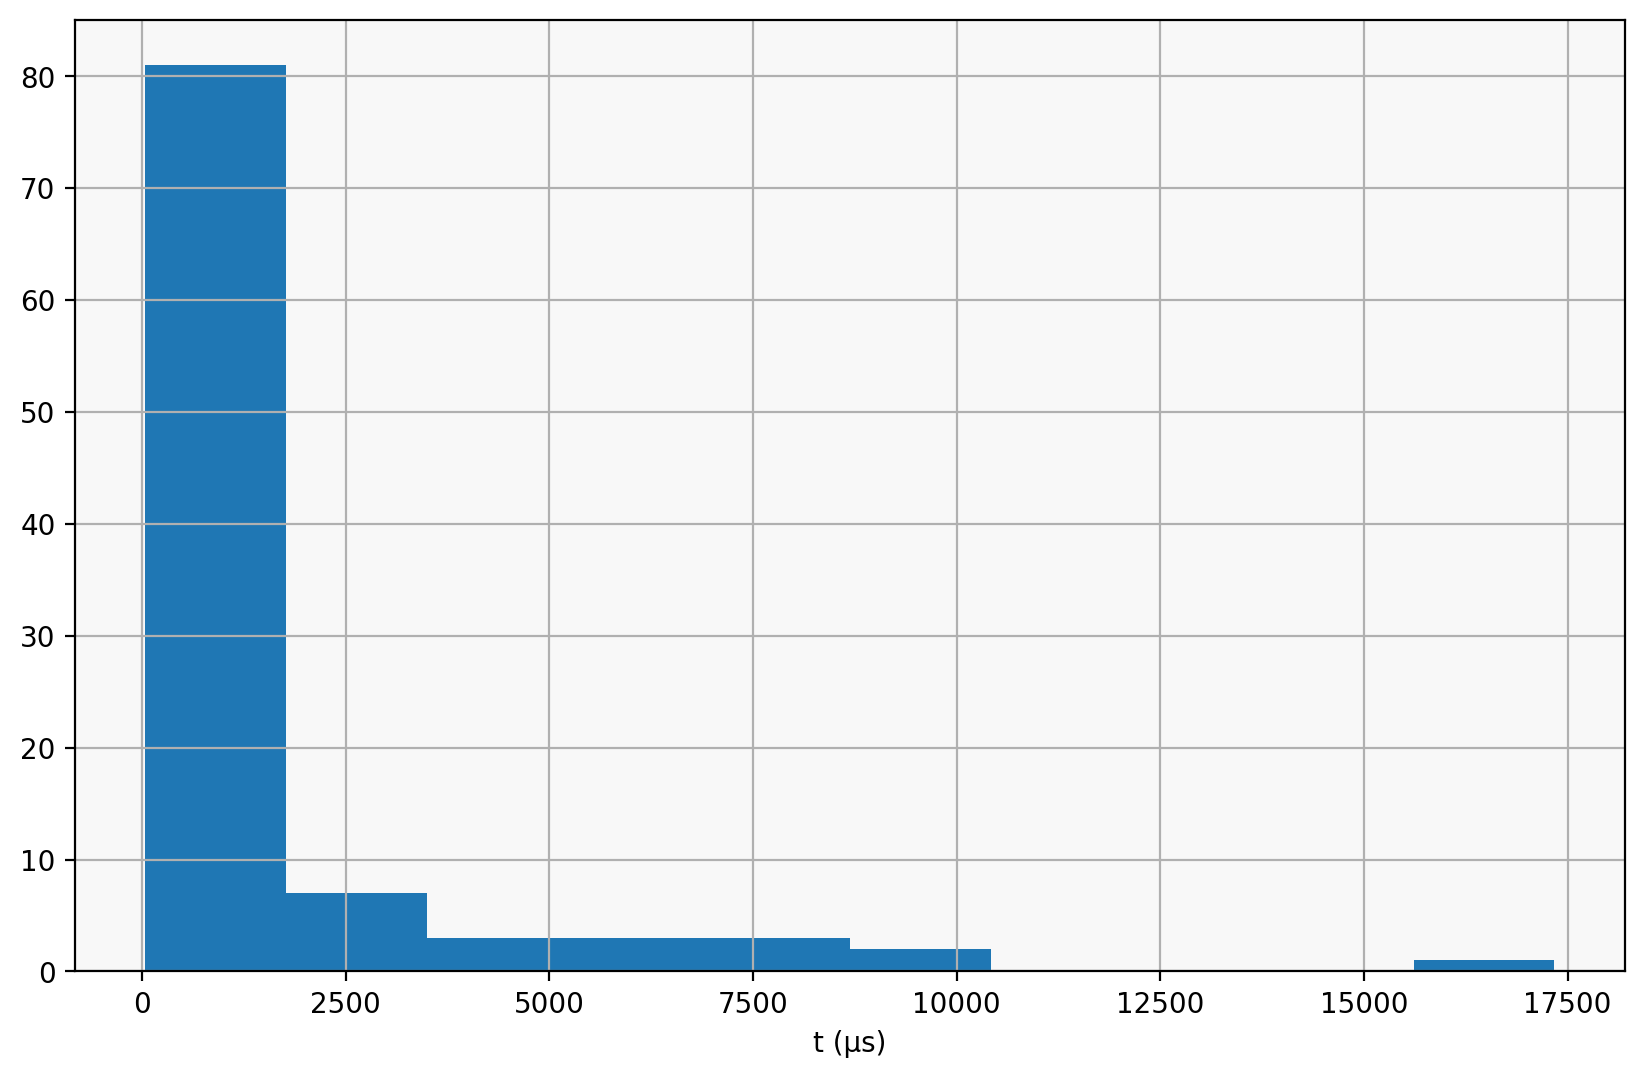

In [9]:
plt.hist(np.array(tr.all_runs) * 1e6)
plt.xlabel("t (µs)");

## Diffusing a wave

Our task is to optimise a 1-D diffusion algorithm,
using numpy and Cython.

Our input signal is a sawtooth wave:

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (k t)}{k}
$$

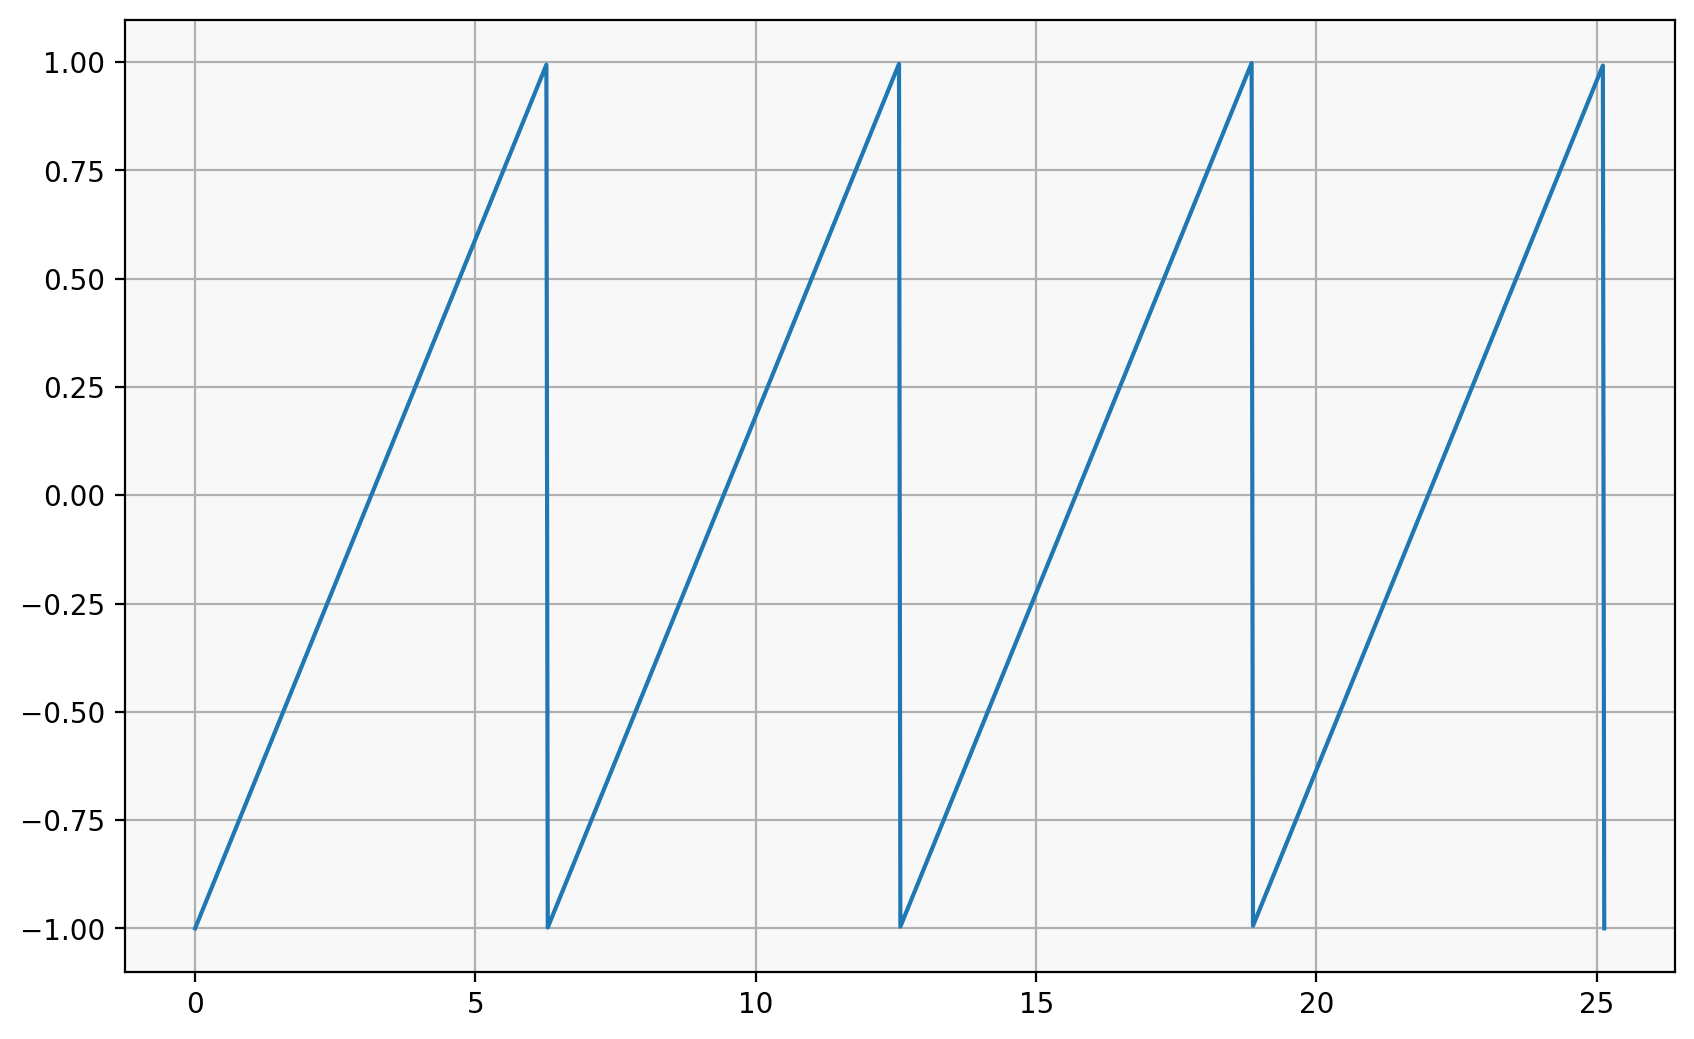

In [11]:
from scipy.signal import sawtooth

T = 8 * np.pi
t = np.linspace(0, T, 1024)
x = sawtooth(t)
plt.plot(t, x)

steps = 10_000

# Exercise: turning math into code



Hints:

1. when you see a sum over a variable, that should make you think of a `for` loop
2. `x(t)` can be an *array*, where `t` is an array of values, and `x` is the result of calling an 

For example, to implement 

$$
x(t) = sin(t)
$$

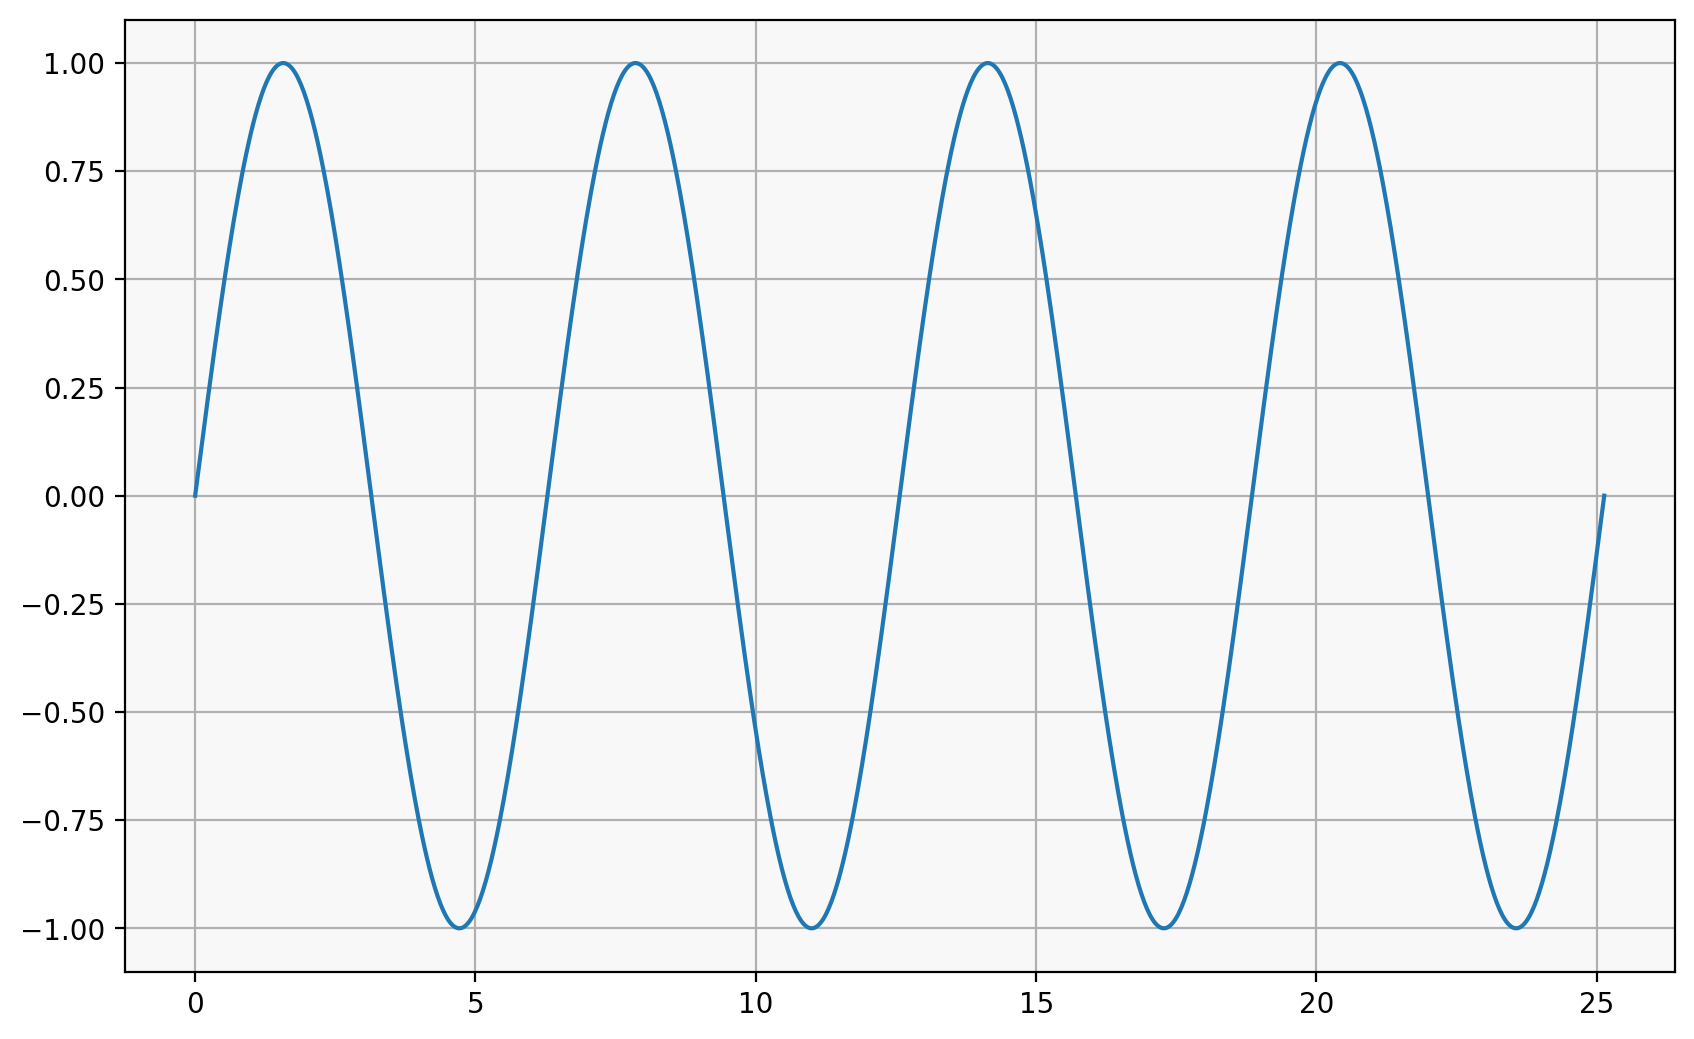

In [12]:
x_t = np.sin(t)
plt.plot(t, x_t)

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (k t)}{k}
$$

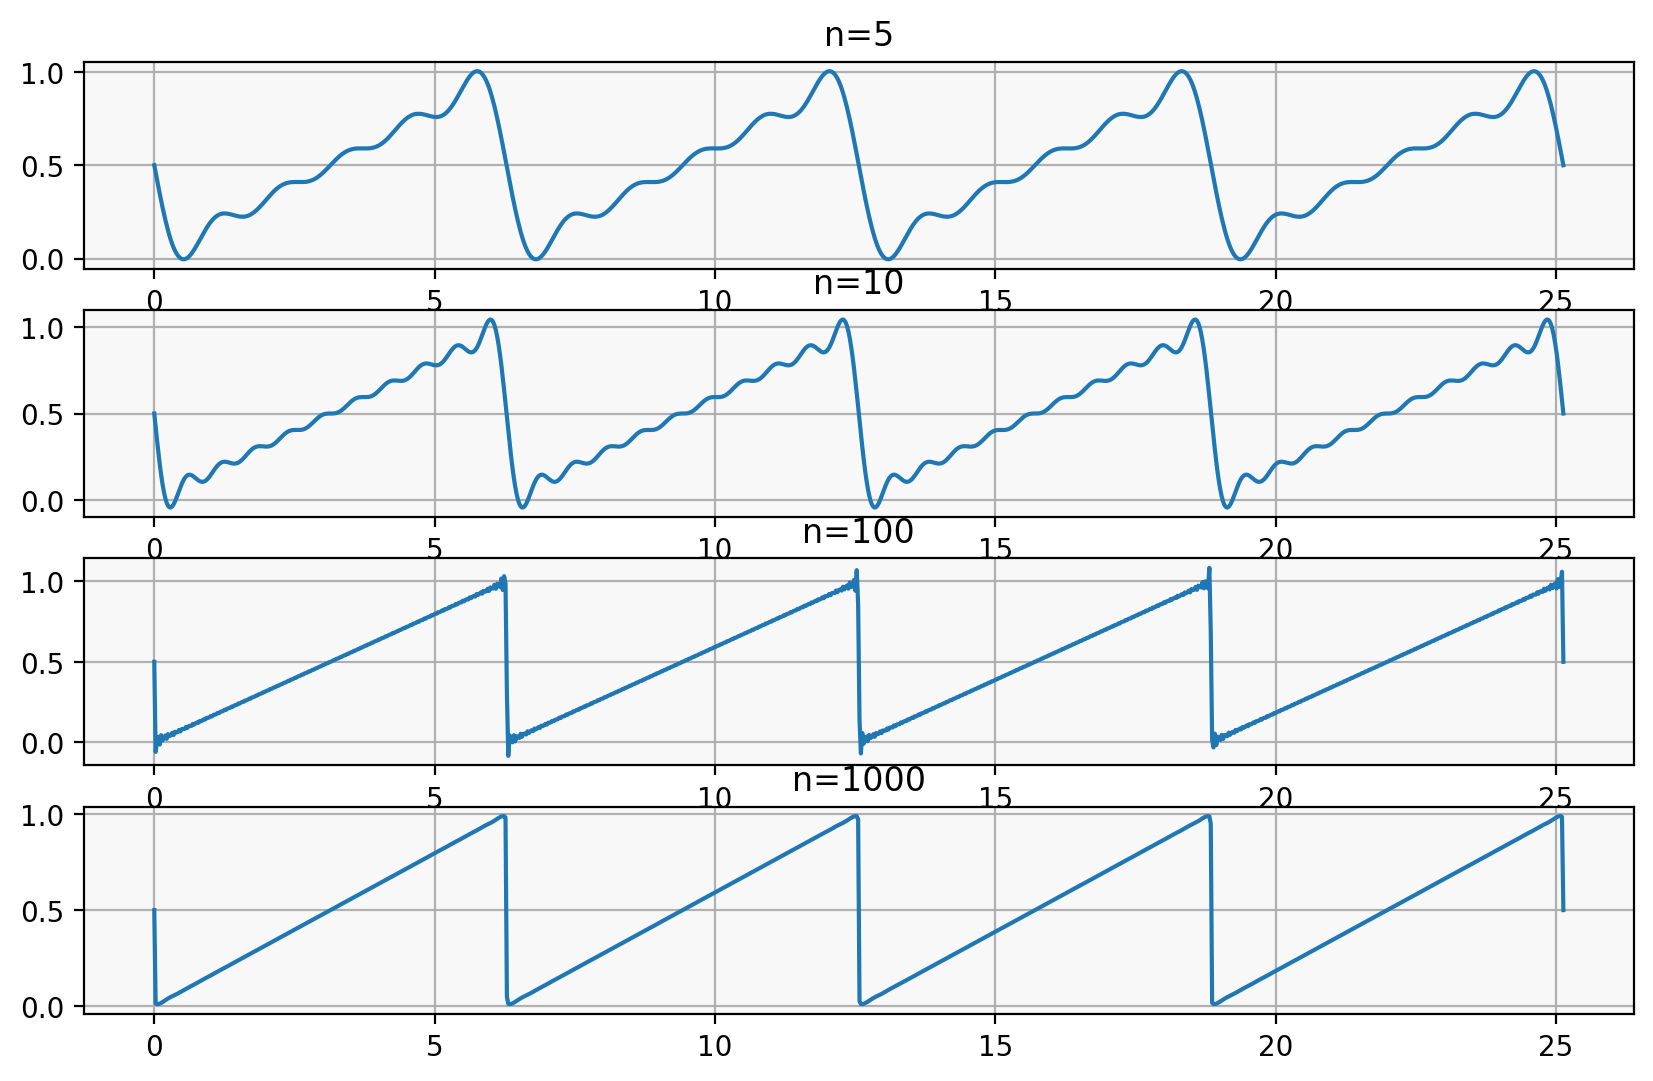

In [13]:
def my_sawtooth(t, A=1, n_freqs=100):
    # x = A/2 - ...
    x = np.ones(t.shape) * 0.5
    # A/π * sum(k=1, k=n_freqs) { sin(k t) / k }
    for k in range(1, n_freqs + 1):
        x -= np.sin(k * t) / (k * np.pi)
    return x * A


# test your sawtooth output
# it should look like similar to the above

n_list = [5, 10, 100, 1000]
fig, axes = plt.subplots(len(n_list), 1)

for ax, n_freqs in zip(axes, n_list):
    ax.plot(t, my_sawtooth(t, n_freqs=n_freqs))
    ax.set_title(f"n={n_freqs}")

We are going to diffuse the wave by evolving the heat equation:

$$
\frac{\delta x}{\delta t} = \alpha \frac{\delta^2 x}{\delta t^2}
$$

Which we can discretize for our arrays:

\begin{align}
x_{k}[i] =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) & i \in [1, N-1] \\
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
\end{align}

Text(2, 11, '1/4')

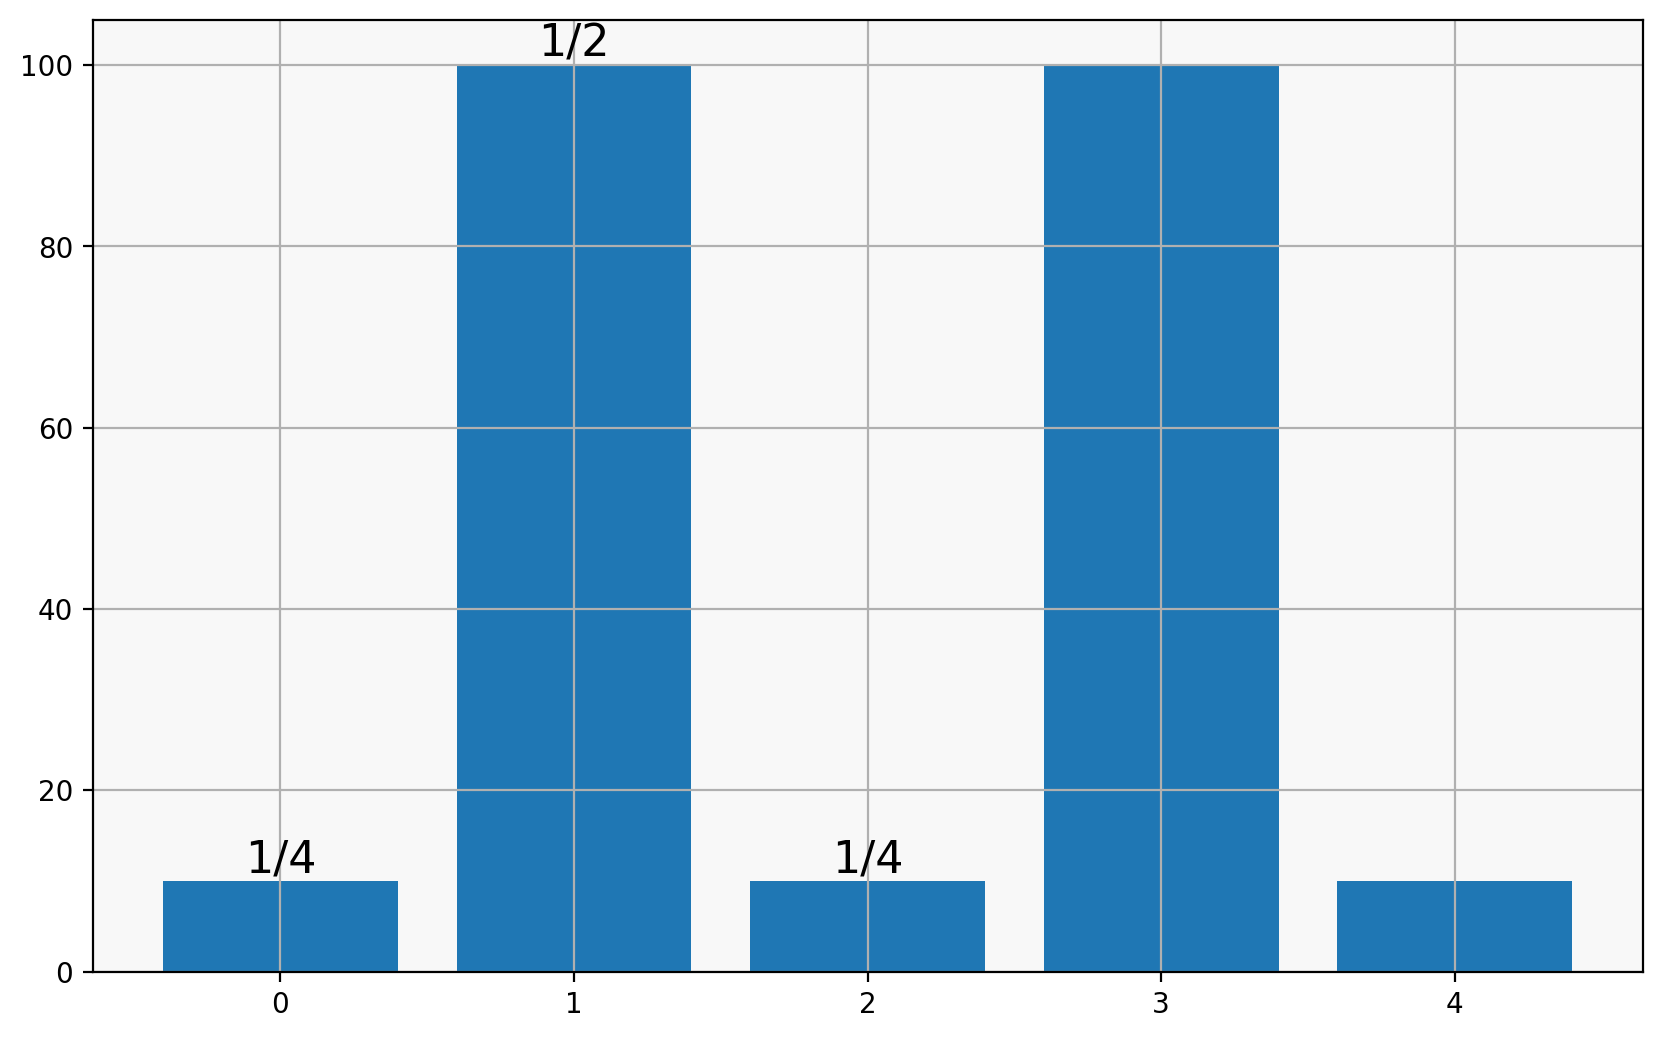

In [14]:
points = [10, 100, 10, 100, 10]

plt.bar(range(len(points)), points)
plt.text(1, 101, "1/2", size=16, ha="center")
plt.text(0, 11, "1/4", size=16, ha="center")
plt.text(2, 11, "1/4", size=16, ha="center")

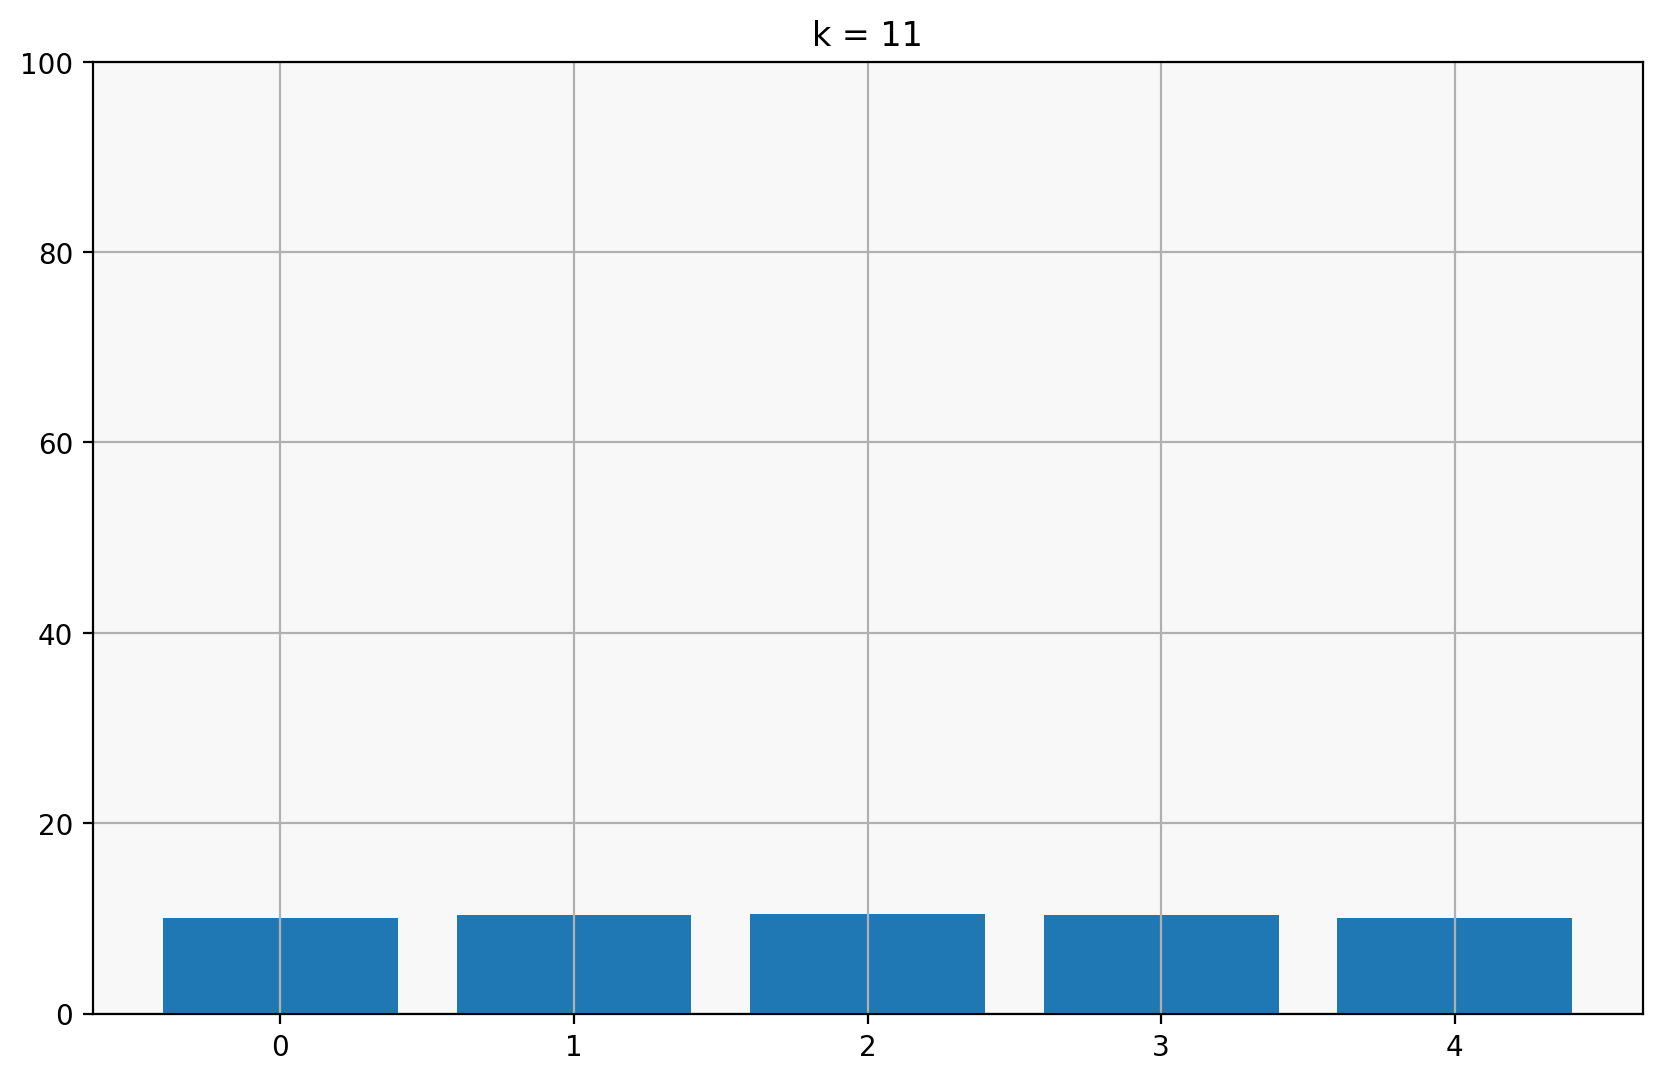

In [16]:
import time

from IPython.display import clear_output

i_list = range(len(points))
for k in range(12):
    plt.bar(range(len(points)), points)
    plt.ylim(0, 100)
    plt.title(f"k = {k}")
    plt.show()
    next_points = points.copy()
    for i in range(1, len(points) - 1):
        next_points[i] = 0.25 * points[i - 1] + 0.5 * points[i] + 0.25 * points[i + 1]
    points = next_points
    time.sleep(1)
    clear_output(wait=True)

## Pure Python

We'll start with a pure Python implementation,
to use as a reference.

Let's implement our algorithm:

Advancing our blur *one step* looks like:

\begin{align}
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
x_{k}[i] =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) & i \in [1, N-1]
\end{align}

and we keep repeating that to get

$$
x_k \in 1...steps
$$

- What variables do we need?
- How many loops?

In [17]:
def blur_py(x0, steps=1024):
    """Advance a Gaussian blur `steps` steps"""
    x = 1 * x0  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for k in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x

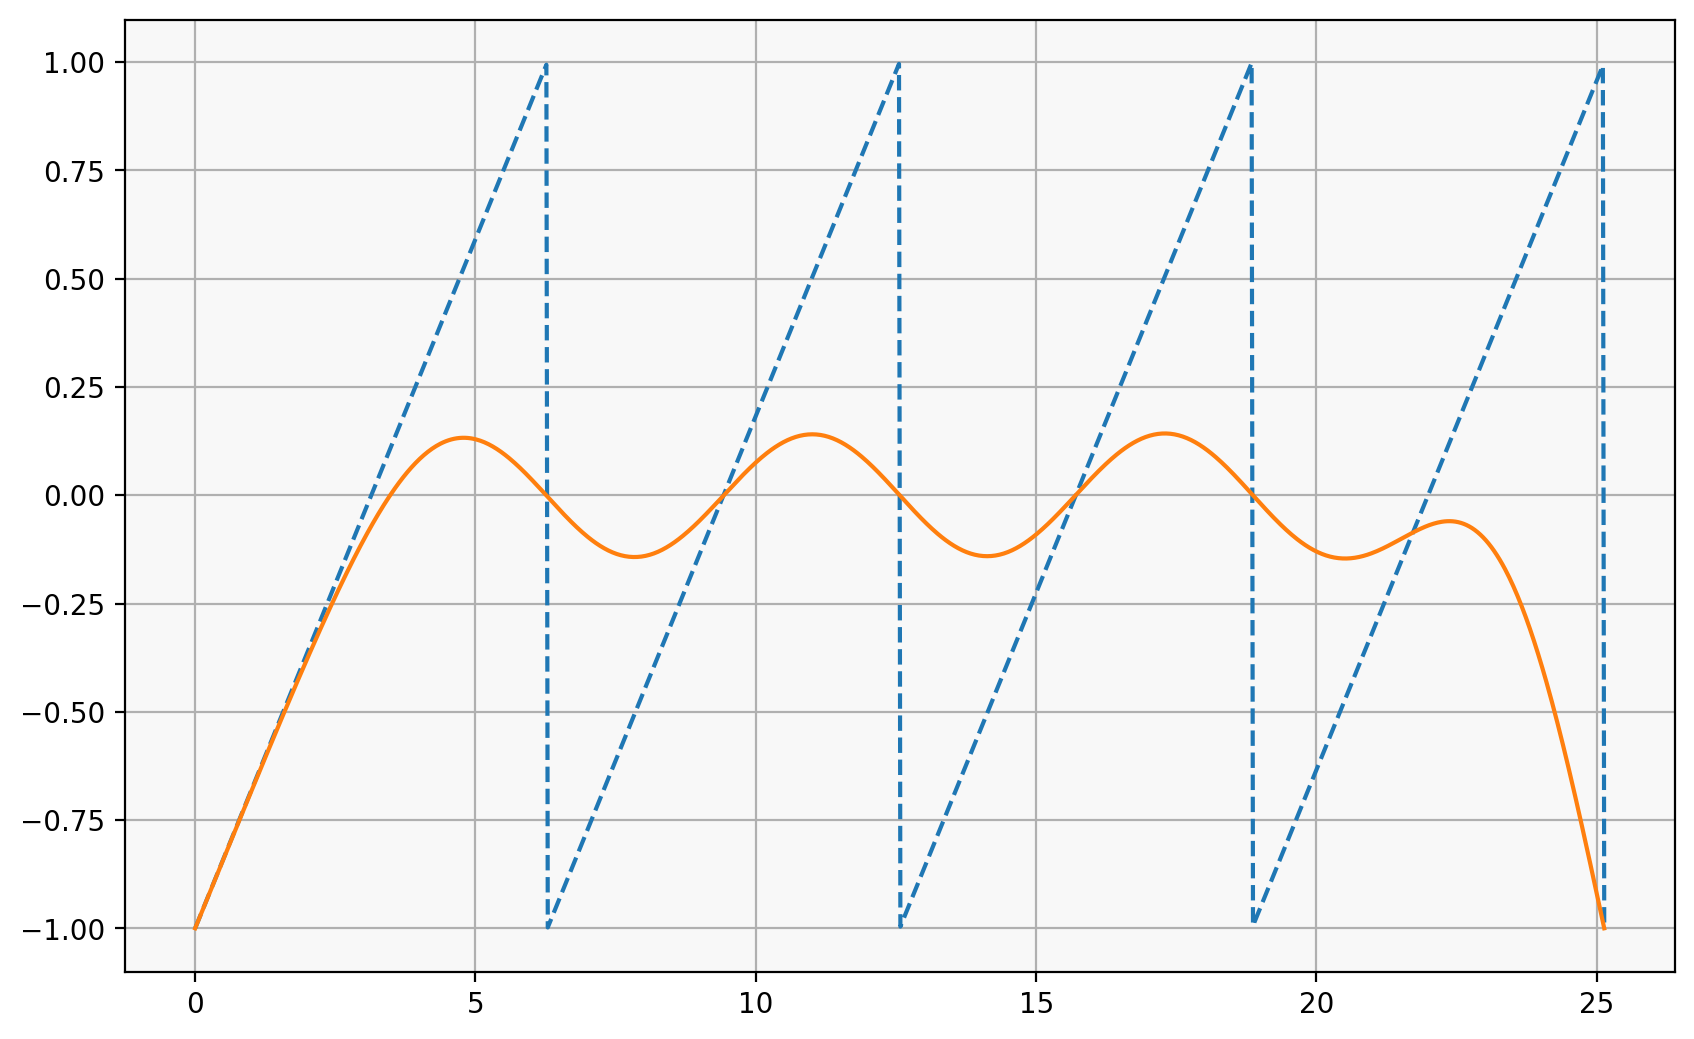

In [19]:
y = blur_py(x, steps)
plt.plot(t, x, "--")
plt.plot(t, y);

Now we can measure how long it takes to run evolve this system:

In [20]:
ref_run = %timeit -o y = blur_py(x, steps)
t_ref = ref_run.best

times = {"python": t_ref}

2.84 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So it takes a few seconds.
We can also see how it changes with different times and resolutions.

## Vectorizing with numpy

We can vectorize the inner loop with a single numpy operation:

In [21]:
import numpy as np


def blur_np(x, steps=1024):
    x = 1 * x
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        x_k[1:-1] = 0.25 * (x[0:-2] + 2 * x[1:-1] + x[2:])
        x, x_k = x_k, x
    return x

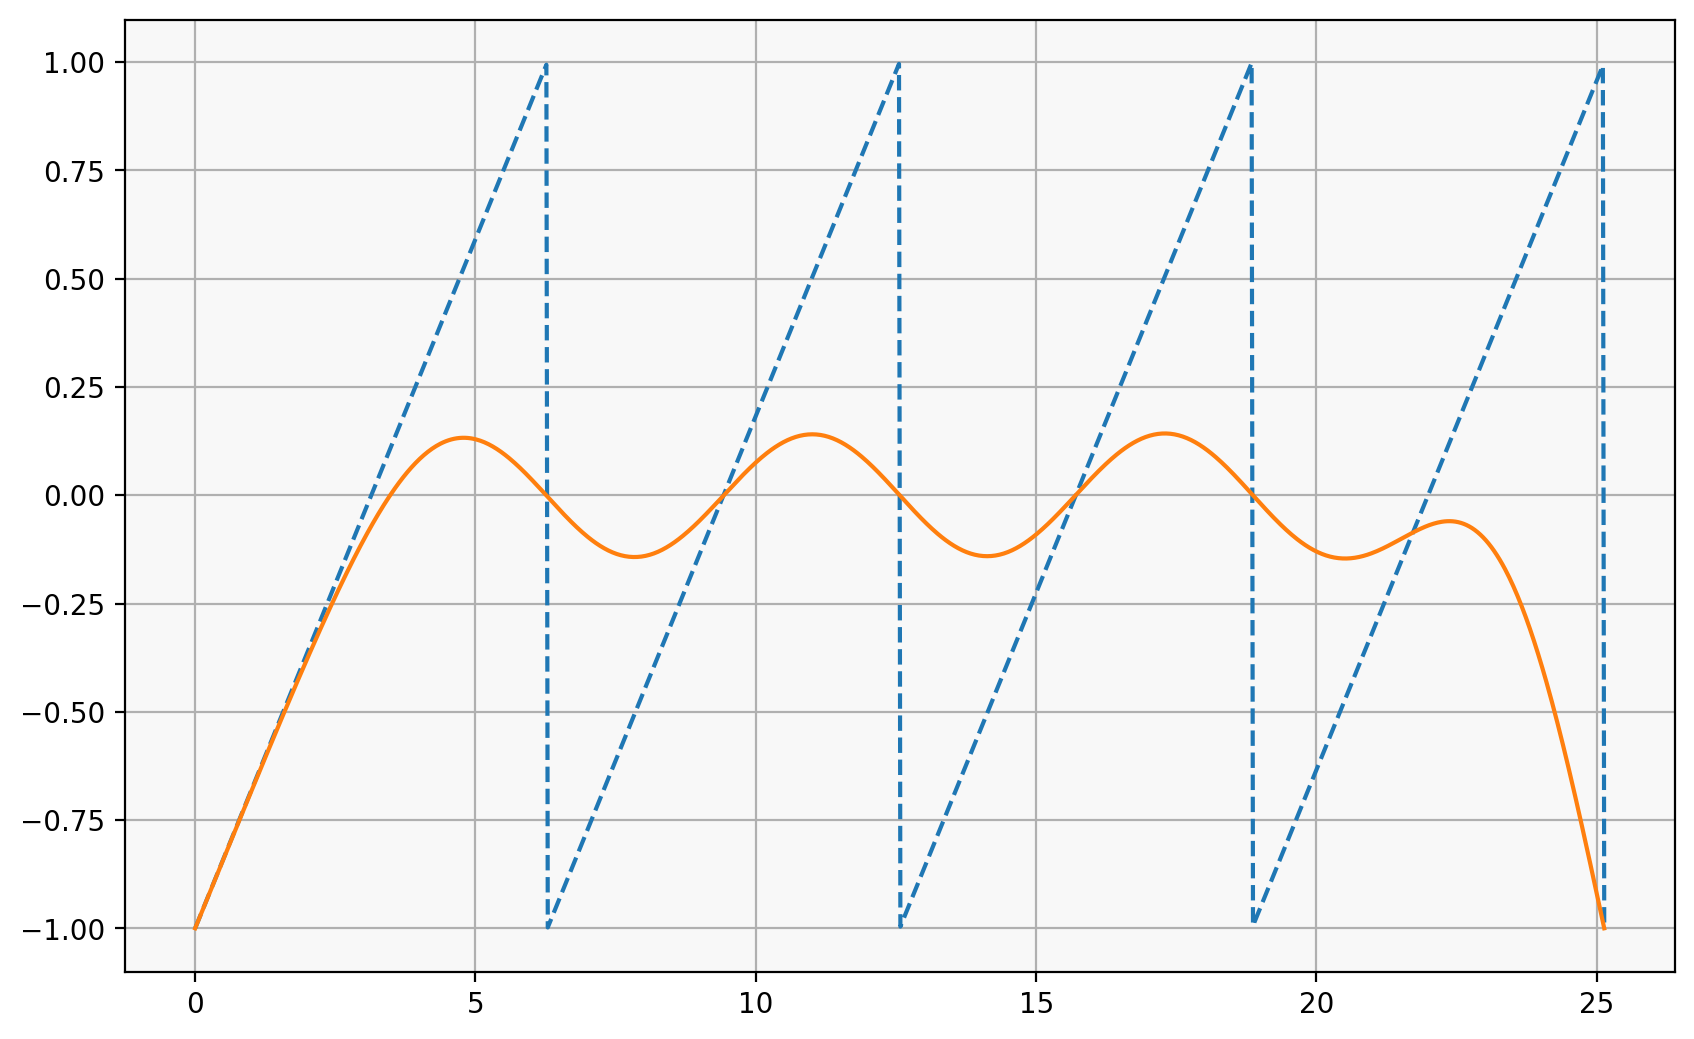

In [22]:
y = blur_np(x, steps)
plt.plot(t, x, "--")
plt.plot(t, y)

In [23]:
np_r = %timeit -o blur_np(x, steps)
t_np = np_r.best

32.3 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
times["numpy"] = t_np

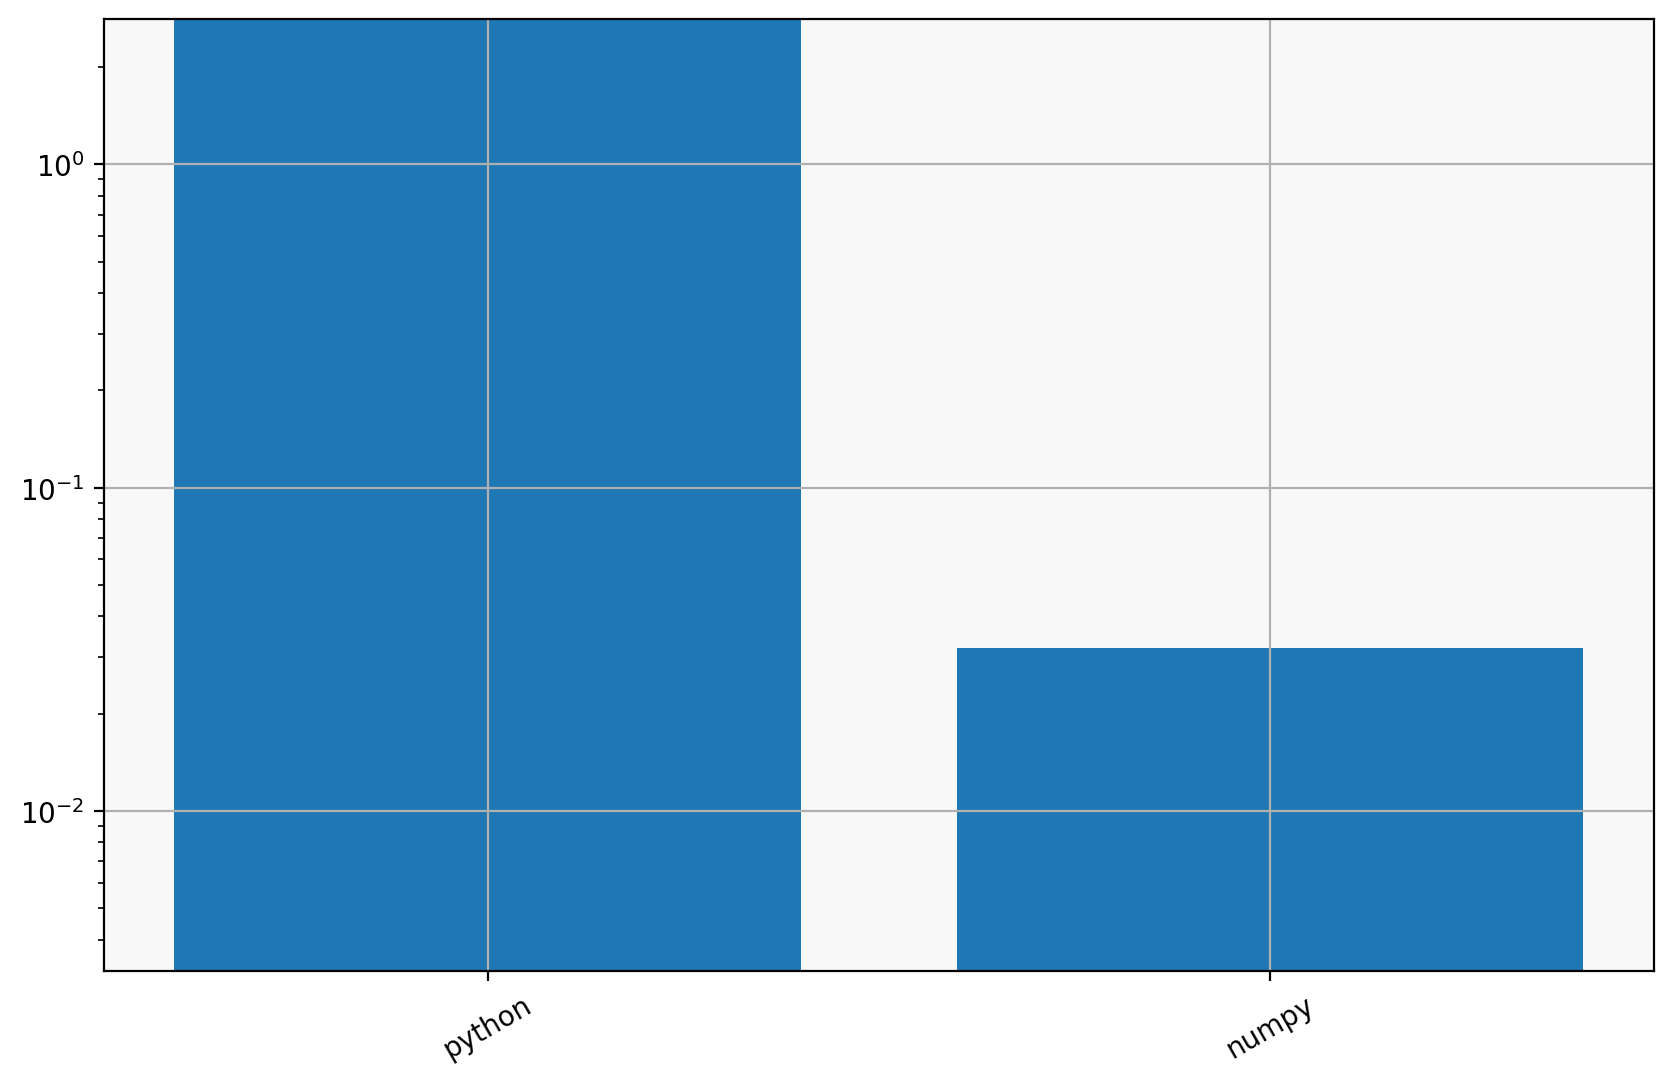

In [25]:
def plot_times():
    ind = np.arange(len(times))
    plt.bar(ind, times.values(), log=True)
    plt.xticks(ind, times.keys(), rotation=30)
    plt.ylim(0.1 * min(times.values()), max(times.values()))


plot_times()

So vectorizing the inner loop brings us from O(1 second) to O(10 milliseconds),
an improvement of ~100x:

In [26]:
t_ref / t_np

88.01331876252759

# Cython

[Cython](http://cython.org/) provides an IPython extension,
which defines a magic we can use to inline bits of Cython code in the notebook:

In [27]:
%load_ext Cython

In [28]:
%%cython

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [29]:
%timeit csum(5)

147 ns ± 0.263 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [30]:
%%cython?

Docstring:
::

  %cython [-a] [--annotate-fullc] [-+] [-3] [-2] [-f] [-c COMPILE_ARGS]
              [--link-args LINK_ARGS] [-l LIB] [-n NAME] [-L dir] [-I INCLUDE]
              [-S SRC] [--pgo] [--verbose]

Compile and import everything from a Cython code cell.

The contents of the cell are written to a `.pyx` file in the
directory `IPYTHONDIR/cython` using a filename with the hash of the
code. This file is then cythonized and compiled. The resulting module
is imported and all of its symbols are injected into the user's
namespace. The usage is similar to that of `%%cython_pyximport` but
you don't have to pass a module name::

    %%cython
    def f(x):
        return 2.0*x

To compile OpenMP codes, pass the required  `--compile-args`
and `--link-args`.  For example with gcc::

    %%cython --compile-args=-fopenmp --link-args=-fopenmp
    ...

To enable profile guided optimisation, pass the ``--pgo`` option.
Note that the cell itself needs to take care of establishing a suitable
prof

`%%cython --annotate` shows you annotations about the generated sourcecode.
The key to writing Cython is to minimize the amount of Python calls in the generated code. In general: yellow = slow.

In [31]:
def psum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [32]:
%%cython --annotate

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

Uh oh, that looks like a lot of yellow.
We can reduce it by adding some type annotations:

In [33]:
%%cython --annotate

from cython import int

def csum2(n: int):
    i: int
    cs = 0
    for i in range(n):
        cs += i
    return cs

Almost there, but I still see yellow on the lines with `cs`:

In [34]:
%%cython --annotate
from cython import int

def csum3(n: int) -> int:
    i: int
    cs: int = 0
    for i in range(n):
        cs += i
    return cs

Much better!
Now there's only Python when entering the function,
which is about as good as we can do.

In [35]:
N = 1_000_000
print("psum ", end=" ")
tr_psum = %timeit -o psum(N)
print("csum ", end=" ")
tr_csum = %timeit -o csum(N)
print("csum2", end=" ")
tr_csum2 = %timeit -o csum2(N)
print("csum3", end=" ")
tr_csum3 = %timeit -o csum3(N)

psum  22.7 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
csum  20.3 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
csum2 19.7 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
csum3 24.8 ns ± 0.737 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [36]:
from IPython.display import Markdown

Markdown(
    f"""

| function | speedup |
| --- | --- |
| psum | 1.0 (reference) |
| csum | {tr_psum.average / tr_csum.average:.2f}x |
| csum2 | {tr_psum.average / tr_csum2.average:.2f}x |
| csum3 | {tr_psum.average / tr_csum3.average:,.0f}x |
"""
)



| function | speedup |
| --- | --- |
| psum | 1.0 (reference) |
| csum | 1.12x |
| csum2 | 1.15x |
| csum3 | 916,209x |


## Blurring with Cython

Now we can apply the same principles to writing a blur
in Cython.

In [37]:
%%cython --annotate

import numpy as np


def blur_cython(x, steps=1024):
    x = 1 * x  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x

In [38]:
c1 = %timeit -o y = blur_cython(x, steps)
t_c1 = c1.best
times["cython (no hints)"] = t_c1

2.74 s ± 53.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


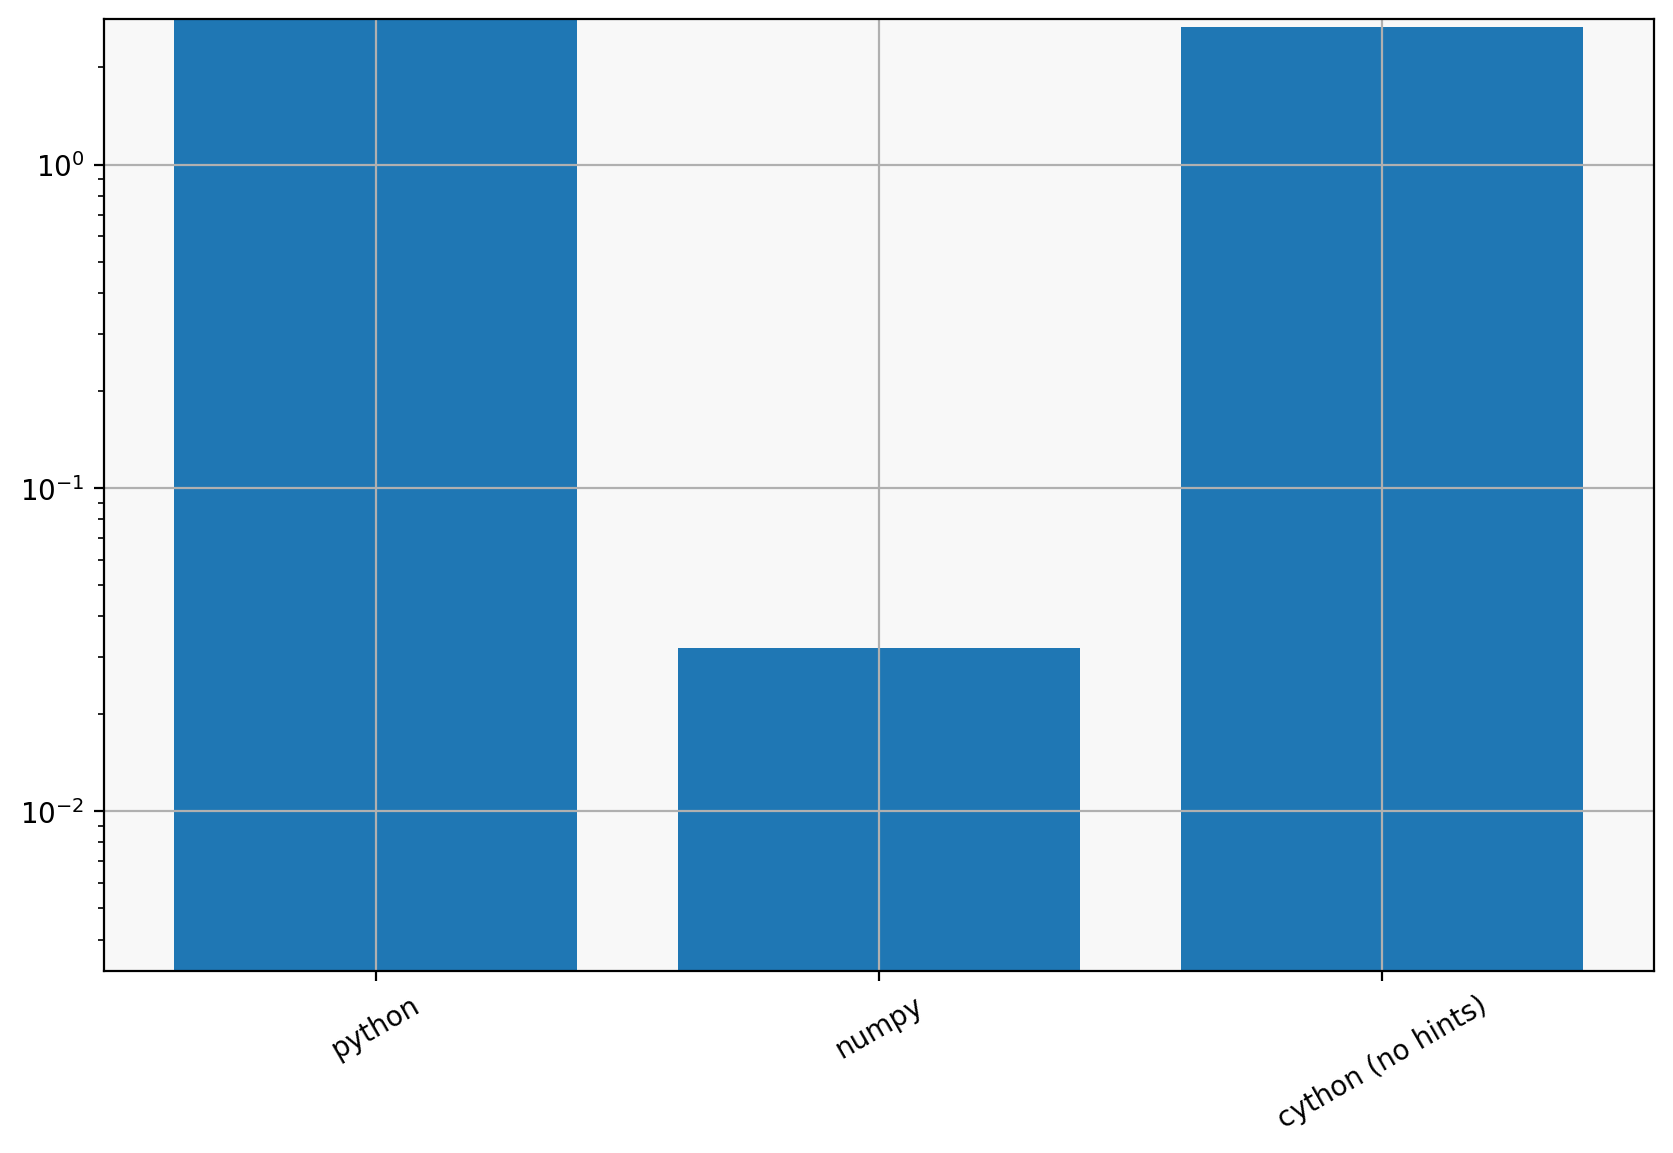

In [39]:
plot_times()

Without annotations, we don't get any real improvement over the pure Python version.
We can note the types of the input arguments, to get some improvements:

In [40]:
%%cython --annotate

import cython as C
import numpy as np

def blur_cython2(x: C.double[:], steps: C.int=1024):
    x = x.copy()
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    i: C.size_t
    N: C.size_t = len(x)
    for _ in range(steps):
        for i in range(1, N-1):
            x_k[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, x_k = x_k, x # swap for next step
    return np.asarray(x)

863 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


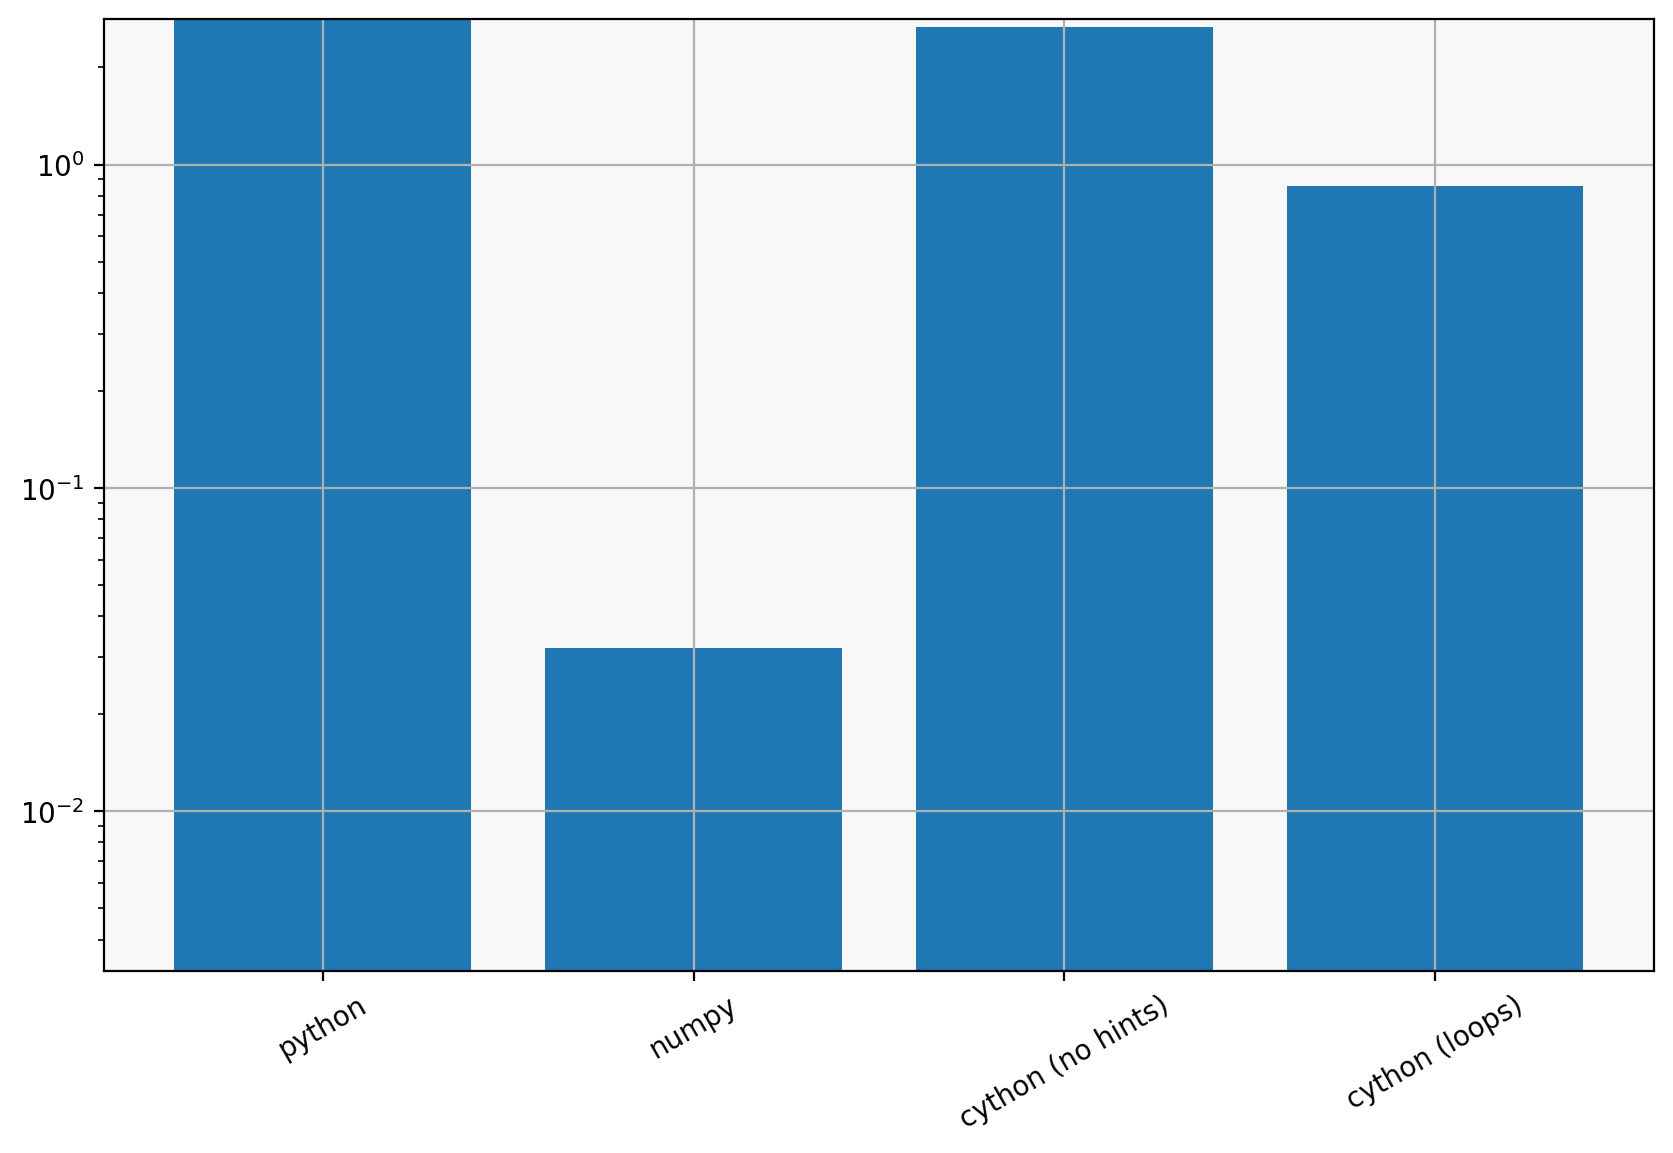

In [41]:
c2 = %timeit -o blur_cython2(x, steps)
t_c2 = c2.best
times["cython (loops)"] = t_c2
plot_times()

Just by making sure the iteration variables are defined as integers, we can save about 80% of the time.

The biggest key to optimizing with Cython is getting that yellow out of your loops.
The more deeply nested a bit of code is within a loop,
the more often it is called, and the more value you can get out of making it fast.
In Cython, fast means avoiding Python (getting rid of yellow).
To get rid of Python calls, we need to tell Python about the numpy arrays `x` and `y`:


In [42]:
%%cython --annotate

import cython as C
import numpy as np


def blur_cython_typed(x_: C.double[::1], steps: C.int = 1024):
    i: C.size_t
    N: C.size_t = x_.shape[0]
    x: C.double[::1] = x_.copy()
    x_k: C.double[::1] = np.empty_like(x_)
    x_k[0] = x[0]
    x_k[N - 1] = x[N - 1]
    for _ in range(steps):
        for i in range(1, N - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return np.asarray(x)

1.78 ms ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


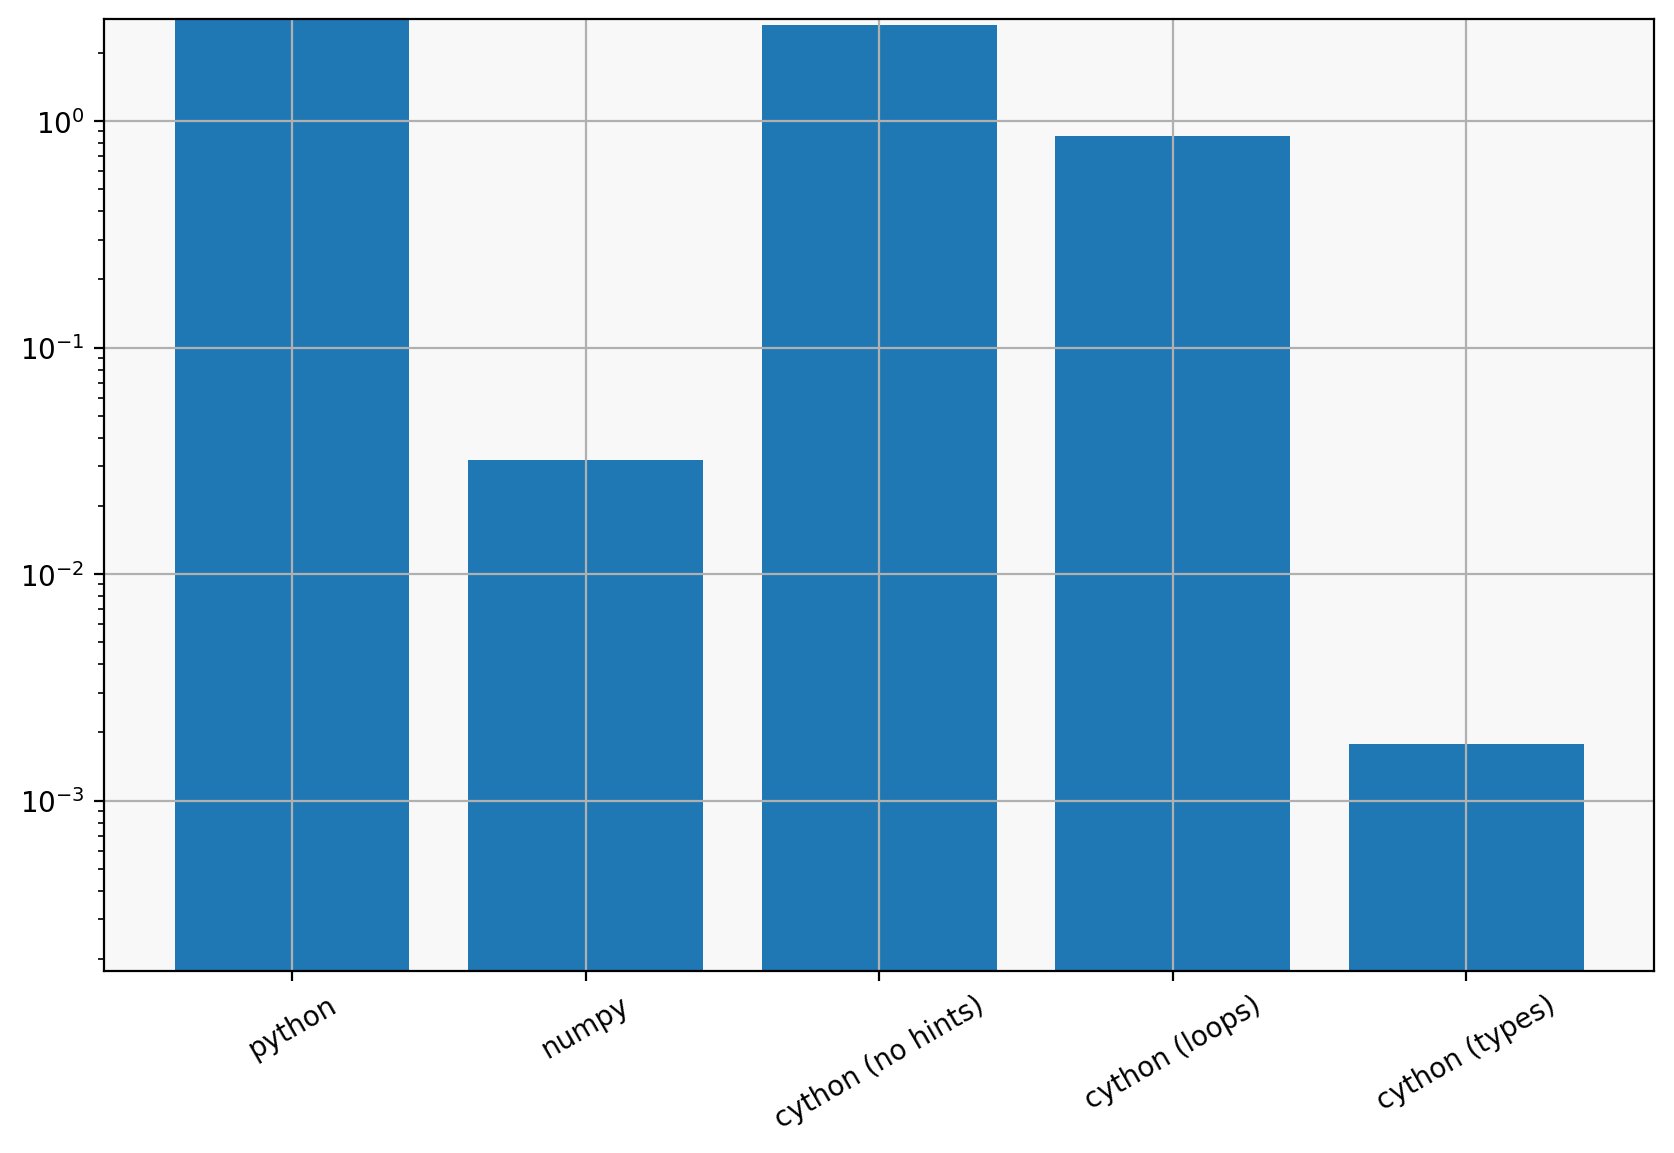

In [43]:
ct = %timeit -o y = blur_cython_typed(x, steps)
t_ct = ct.best

times["cython (types)"] = t_ct
plot_times()

We can further optimize with Cython macros,
which disable bounds checking and negative indexing,
and avoiding the Python variable swaping by using indices into a single array:

In [44]:
x[len(x)]

IndexError: index 1024 is out of bounds for axis 0 with size 1024

In [45]:
%%cython --annotate

import cython as C
import numpy as np


@C.boundscheck(False)
@C.wraparound(False)
def blur_cython_optimized(x_: C.double[::1], steps: C.int = 1024) -> C.double[::1]:
    i: C.size_t
    N: C.size_t = x_.shape[0]
    x: C.double[::1] = x_.copy()
    x_k: C.double[::1] = np.empty_like(x_)
    x_k[0] = x[0]
    x_k[N - 1] = x[N - 1]
    for _ in range(steps):
        for i in range(1, N - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return np.asarray(x)

Note how there is now zero yellow called in any of the loops,
only in the initial copy of the input array.

1.86 ms ± 8.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


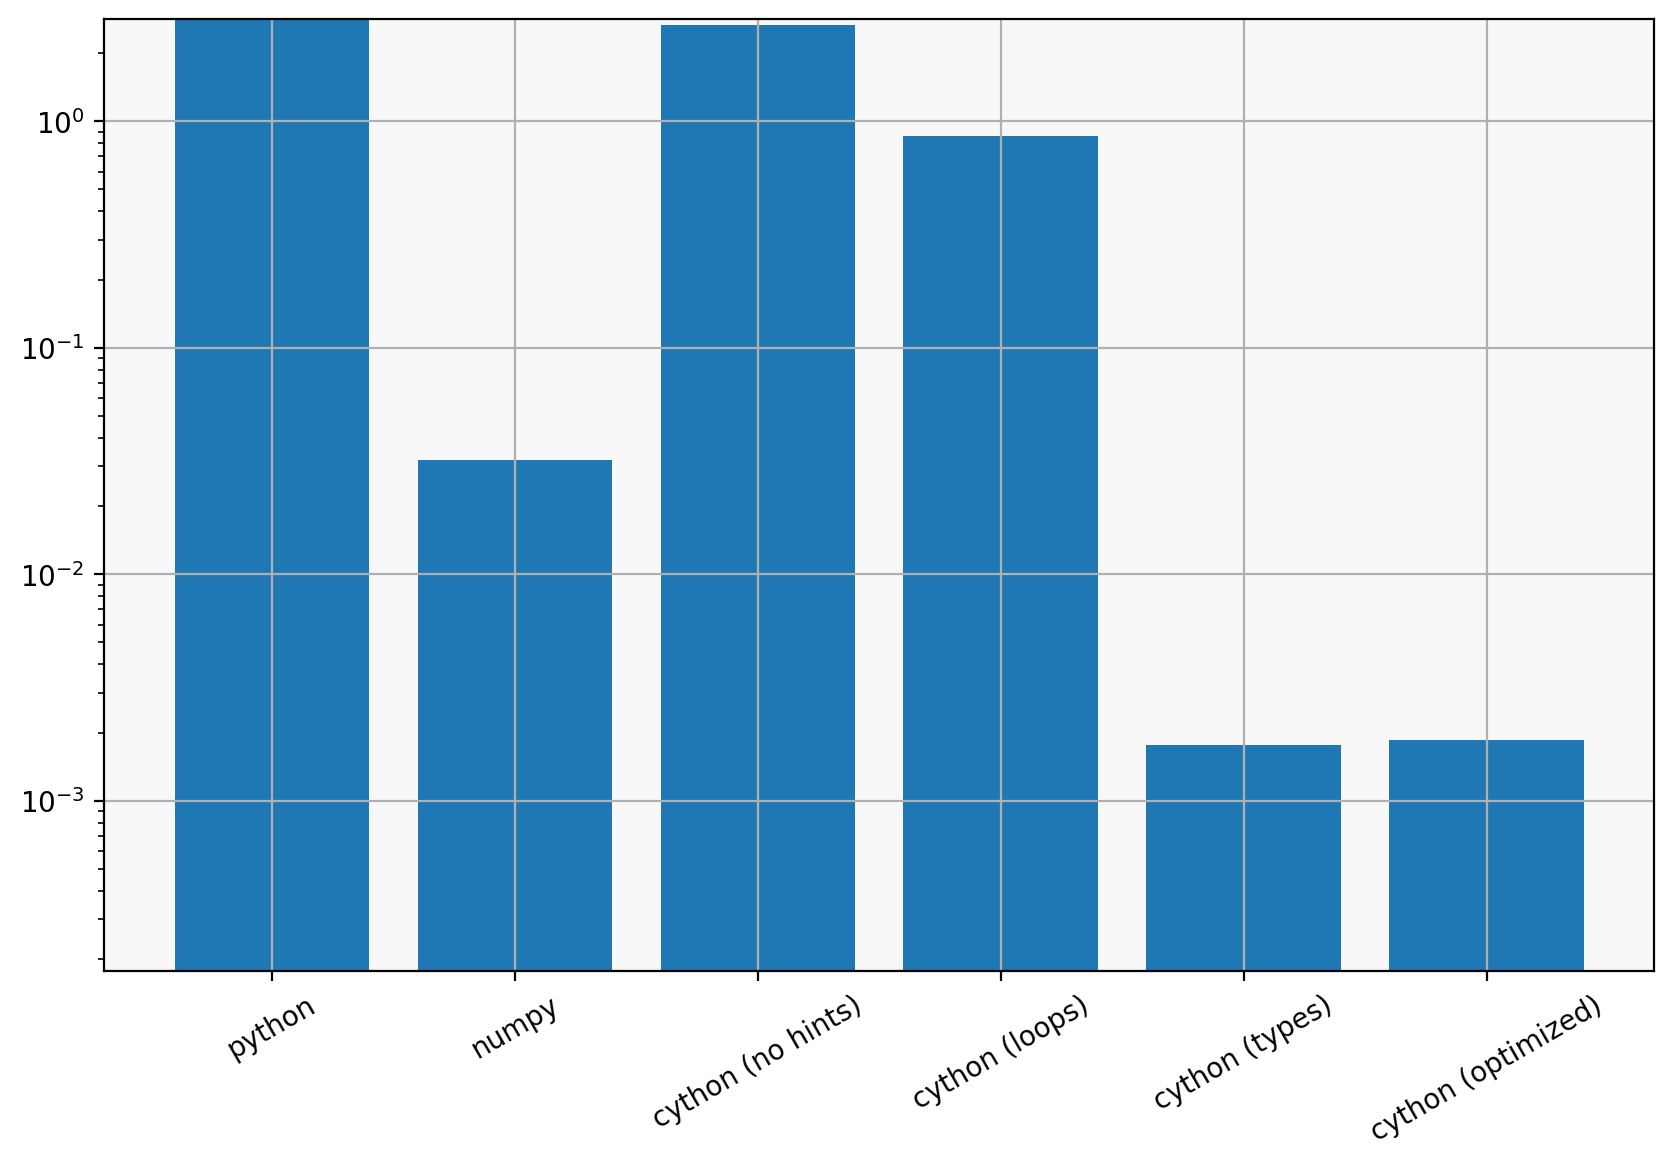

In [46]:
copt = %timeit -o y = blur_cython_optimized(x, steps)
t_copt = copt.best
times["cython (optimized)"] = t_copt
plot_times()

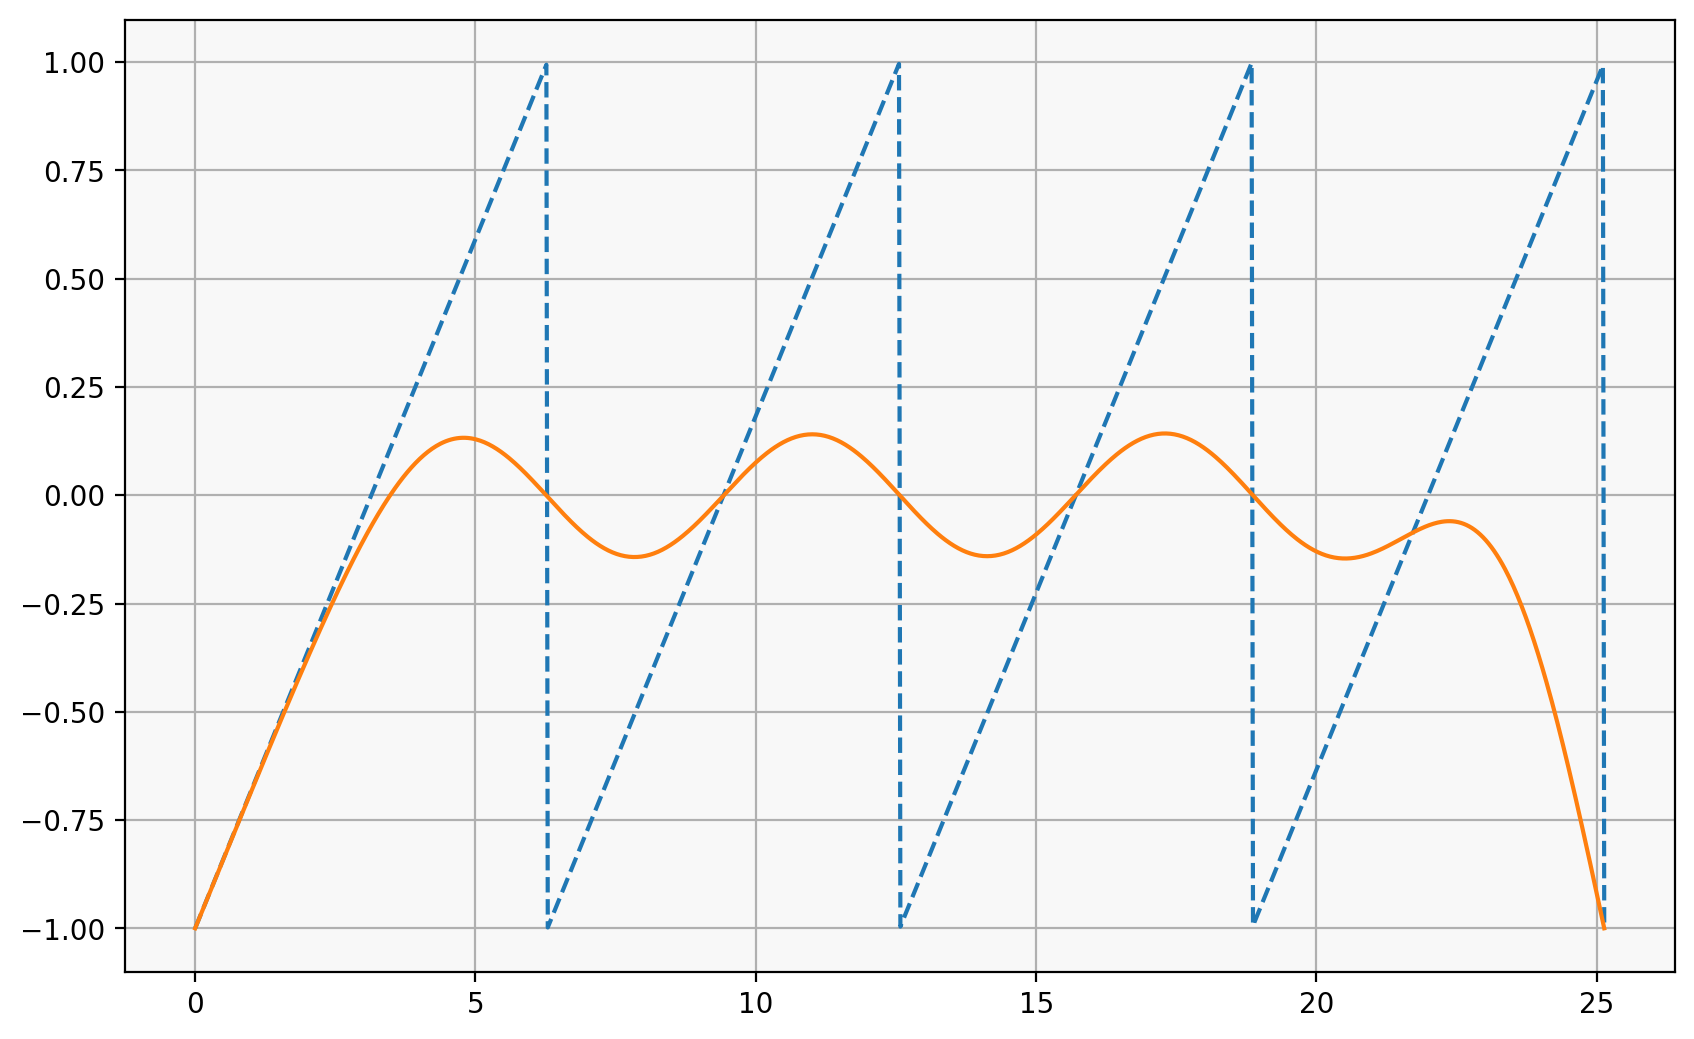

In [47]:
y = blur_cython_optimized(x, steps)  # noqa: F821
plt.plot(t, x, "--")
plt.plot(t, y)

## numba

[numba](http://numba.pydata.org/) is a library that attempts to automatically do type-based optimizations like we did with Cython.
To use numba, you decorate functions with `@autojit`.

In [48]:
import numba


@numba.jit(nopython=True)
def blur_numba(x, steps=1024):
    """identical to blur_py, other than the decorator"""
    x = 1 * x  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x


y = blur_numba(x, steps)

2 ms ± 7.37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


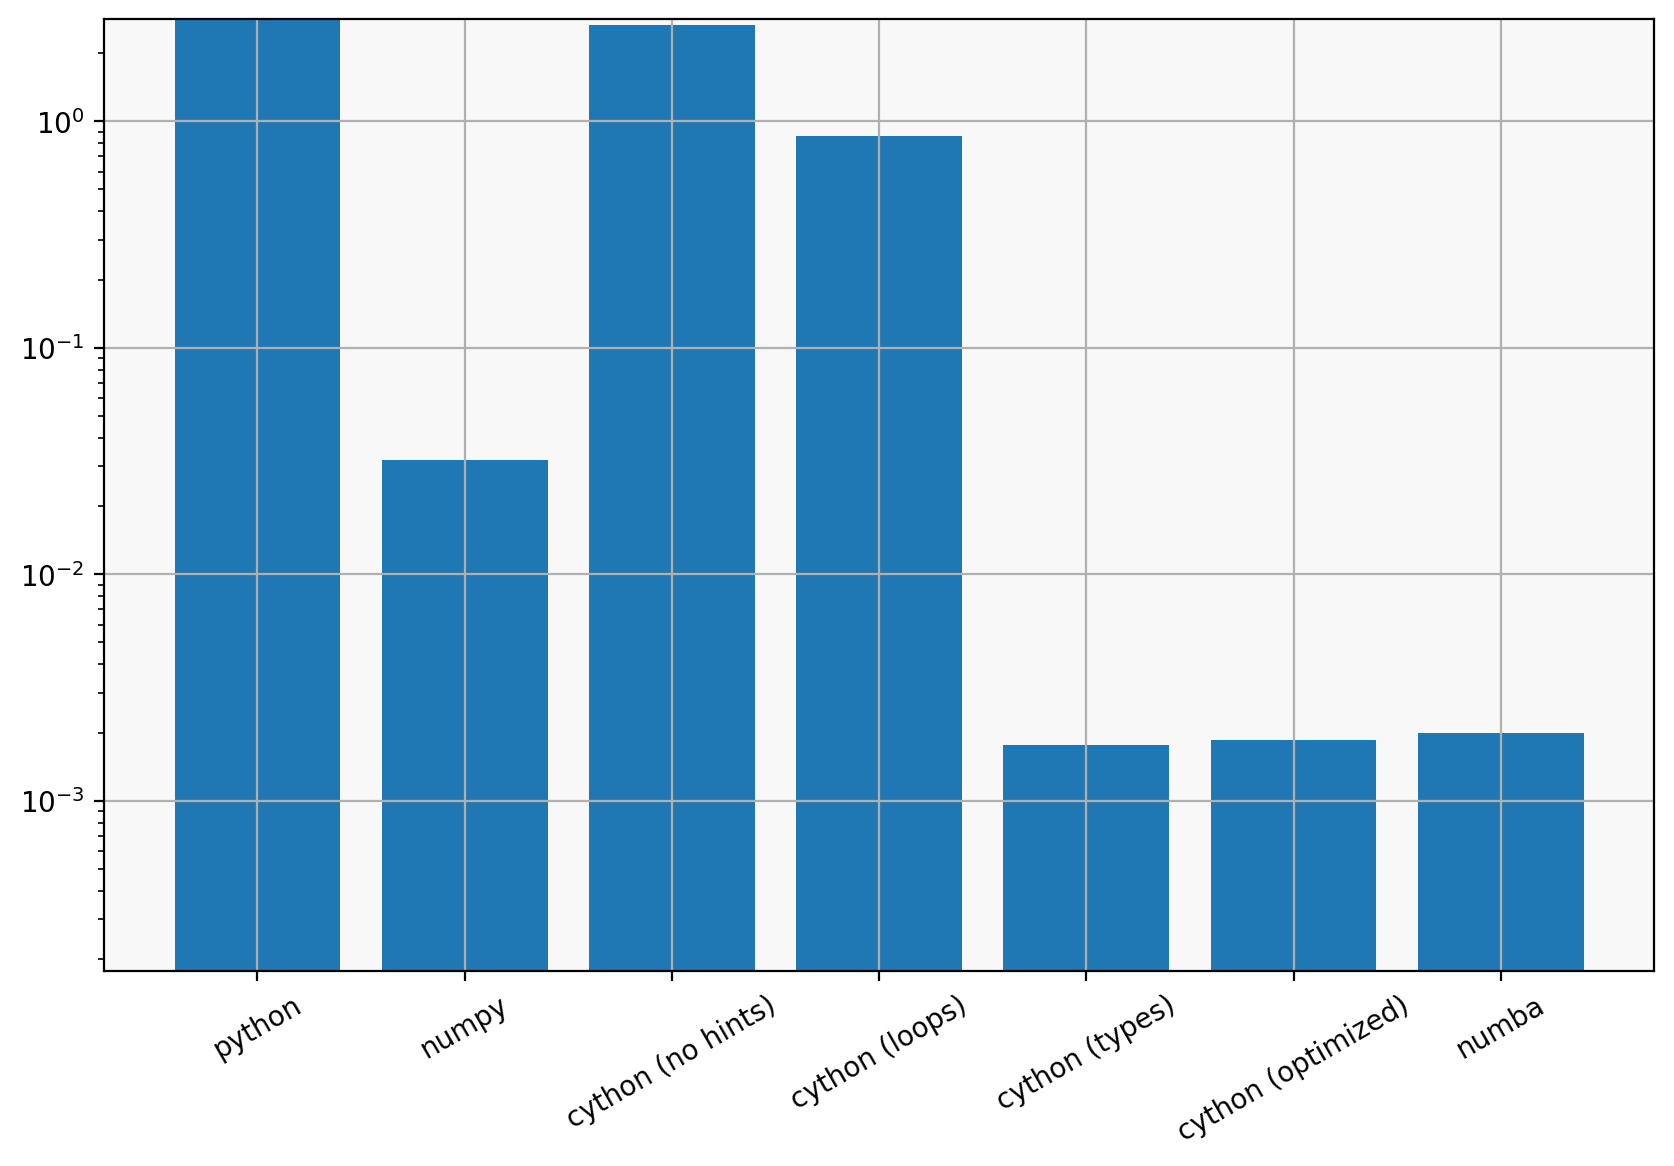

In [49]:
nb = %timeit -o blur_numba(x, steps)
t_nb = nb.best
times["numba"] = t_nb
plot_times()

In [50]:
md = """

| function | speedup |
| --- | --- |
| python | 1.0 (reference) |
"""

for key, value in times.items():
    if key == "python":
        continue
    md += f"| {key} | {t_ref / value:,.2f}x |\n"

Markdown(md)



| function | speedup |
| --- | --- |
| python | 1.0 (reference) |
| numpy | 88.01x |
| cython (no hints) | 1.06x |
| cython (loops) | 3.28x |
| cython (types) | 1,592.13x |
| cython (optimized) | 1,522.66x |
| numba | 1,414.19x |


How did numba do that without any type info?

In [51]:
blur_numba.inspect_types()

blur_numba (Array(float64, 1, 'C', False, aligned=True), int64)
--------------------------------------------------------------------------------
# File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_8873/4028818462.py
# --- LINE 4 --- 
# label 0
#   x = arg(0, name=x)  :: array(float64, 1d, C)
#   steps = arg(1, name=steps)  :: int64

@numba.jit(nopython=True)

# --- LINE 5 --- 

def blur_numba(x, steps=1024):

    # --- LINE 6 --- 

    """identical to blur_py, other than the decorator"""

    # --- LINE 7 --- 
    #   $const4.0 = const(int, 1)  :: Literal[int](1)
    #   del $const4.0
    #   x.1 = arrayexpr(expr=(<built-in function mul>, [const(int, 1), Var(x, 4028818462.py:4)]), ty=array(float64, 1d, C))  :: array(float64, 1d, C)
    #   del x
    #   x.1.2 = x.1  :: array(float64, 1d, C)

    x = 1 * x  # copy

    # --- LINE 8 --- 
    #   $14load_global.3 = global(np: <module 'numpy' from '/Users/minrk/env/3110/lib/python3.11/site-packages/numpy/__init__.py'>)  :: M

What's impressive about numba in this case
is that it is able to beat all but the most optimized of our implementations without any help.
Like Cython, numba can do an even better job when you provide it with more information about how a function will be called.

## Profiling

A script can be run with

```bash
python3 -m cProfile myscript.py
```

In [52]:
import sys

In [53]:
%prun list(os.walk(sys.prefix))

         171751 function calls (143721 primitive calls) in 0.199 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    35351    0.086    0.000    0.086    0.000 {built-in method builtins.next}
     3766    0.039    0.000    0.039    0.000 {built-in method posix.lstat}
     3767    0.035    0.000    0.035    0.000 {built-in method posix.scandir}
31798/3768    0.024    0.000    0.198    0.000 <frozen os>:345(_walk)
     3766    0.006    0.000    0.008    0.000 <frozen posixpath>:71(join)
    31584    0.002    0.000    0.002    0.000 {method 'is_dir' of 'posix.DirEntry' objects}
    31584    0.002    0.000    0.002    0.000 {method 'append' of 'list' objects}
     3766    0.002    0.000    0.041    0.000 <frozen posixpath>:164(islink)
        1    0.001    0.001    0.199    0.199 <string>:1(<module>)
     3766    0.001    0.000    0.001    0.000 <frozen posixpath>:41(_get_sep)
     3766    0.001    0.000    0.001    0.000 {metho

Snakeviz instaleld with:

    python3 -m pip install snakeviz

In [56]:
%load_ext snakeviz

In [60]:
%snakeviz -t blur_py(x, steps)

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmp8ap5c43p'.
Opening SnakeViz in a new tab...


In [61]:
import hashlib

In [62]:
%%snakeviz -t
for dirpath, dirnames, filenames in os.walk('/usr/local'):
    for filename in filenames:
        if filename.endswith('.txt'):
            full_path = os.path.join(dirpath, filename)
            with open(full_path, 'rb') as f:
                hashlib.md5(f.read())

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpgodj5_5s'.
Opening SnakeViz in a new tab...


line_profiler installed with:

    python3 -m pip install line_profiler

In [63]:
%load_ext line_profiler

In [64]:
%lprun -f blur_py blur_py(x, steps)

Timer unit: 1e-09 s

Total time: 5.4376 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_8873/2340594174.py
Function: blur_py at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def blur_py(x0, steps=1024):
     2                                               """Advance a Gaussian blur `steps` steps"""
     3         1     108000.0 108000.0      0.0      x = 1 * x0  # copy
     4         1      46000.0  46000.0      0.0      x_k = np.empty_like(x)
     5         1       5000.0   5000.0      0.0      x_k[0] = x[0]
     6         1       1000.0   1000.0      0.0      x_k[-1] = x[-1]
     7     10001     945000.0     94.5      0.0      for k in range(steps):
     8  10230000  830603000.0     81.2     15.3          for i in range(1, len(x) - 1):
     9  10220000 4604981000.0    450.6     84.7              x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
    10     10000     913000.0     91.3      0.0  

In [65]:
%lprun -f blur_np blur_np(x, steps)

Timer unit: 1e-09 s

Total time: 0.054138 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_8873/109327557.py
Function: blur_np at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def blur_np(x, steps=1024):
     5         1      63000.0  63000.0      0.1      x = 1 * x
     6         1      18000.0  18000.0      0.0      x_k = np.empty_like(x)
     7         1       7000.0   7000.0      0.0      x_k[0] = x[0]
     8         1       2000.0   2000.0      0.0      x_k[-1] = x[-1]
     9     10001    1242000.0    124.2      2.3      for _ in range(steps):
    10     10000   51473000.0   5147.3     95.1          x_k[1:-1] = 0.25 * (x[0:-2] + 2 * x[1:-1] + x[2:])
    11     10000    1333000.0    133.3      2.5          x, x_k = x_k, x
    12         1          0.0      0.0      0.0      return x

In [68]:
%lprun -f blur_numba -f blur_numba.__wrapped__ blur_numba(x, steps)

Timer unit: 1e-09 s

Total time: 0 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_8873/4028818462.py
Function: blur_numba at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           @numba.jit(nopython=True)
     5                                           def blur_numba(x, steps=1024):
     6                                               """identical to blur_py, other than the decorator"""
     7                                               x = 1 * x  # copy
     8                                               x_k = np.empty_like(x)
     9                                               x_k[0] = x[0]
    10                                               x_k[-1] = x[-1]
    11                                               for _ in range(steps):
    12                                                   for i in range(1, len(x) - 1):
    13                                                       x_k[i] = 0.25 *

In [69]:
%lprun -f blur_cython blur_cython(x, steps)

Timer unit: 1e-09 s

In [76]:
%snakeviz -t np.dot(x, x)

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpzm12swvz'.
Opening SnakeViz in a new tab...
